In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from scipy.linalg import svd
from scipy import linalg
from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import cv2
import numpy as np

# def stitch_images(img1, img2):

#     # Convert images to grayscale
#     gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#     # Use Shi-Tomasi corner detection to detect keypoints
#     max_corners = 1000
#     quality_level = 0.01
#     min_distance = 10
#     corners1 = cv2.goodFeaturesToTrack(gray1, max_corners, quality_level, min_distance)
#     corners2, status, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, corners1, None)

#     # Filter out the keypoints with low status
#     good_corners1 = corners1[status == 1]
#     good_corners2 = corners2[status == 1]

#     # Estimate the homography matrix using RANSAC
#     H, _ = cv2.findHomography(good_corners1, good_corners2, cv2.RANSAC)

#     # Warp the second image using the estimated homography
#     height, width = img1.shape[:2]
#     img2_warped = cv2.warpPerspective(img2, H, (width, height))

#     # Blend the two images
#     blend = cv2.addWeighted(img1, 0.5, img2_warped, 0.5, 0)

#     return blend


In [ ]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(img1 , kp_1 , img2 , kp_2 , matches):
    good_draw = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_draw.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1, kp_1 , img2 , kp_2 , good_draw,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    h = V[-1,:]/V[-1,-1]
    h = np.array(h)
    return np.reshape(h ,(3 ,3 ))

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

def good_matches(i1 , i2 , dst_right_img):   
    img1_copy = i1.copy()
    img2_copy = i2.copy()
        
    sift = cv2.SIFT_create()

    kp_1, des_1 = sift.detectAndCompute(img1_copy,None)
    kp_2, des_2 = sift.detectAndCompute(img2_copy,None)

    bf = cv2.BFMatcher()
    
    if dst_right_img:
        matches = bf.knnMatch(des_1 ,des_2, k=2)

        # Lowe's ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance:
                good.append(m)
        # Atleast 10 good points required 
        if len(good)>10:
            src_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)  

    else :
        matches = bf.knnMatch(des_2 ,des_1, k=2)

        # Lowe's ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance:
                good.append(m)
 
        if len(good)>10:
            src_pts = np.float32([ kp_2[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_1[m.trainIdx].pt for m in good ]).reshape(-1,1,2) 

    plot_matches(img1_copy , kp_1 , img2_copy , kp_2 , matches)
    return src_pts , dst_pts , len(good)

def ransac_H(src , dst , good_matches):
    threshold = 1
    iterations = 50
    best_count = 0 
    H_final = np.zeros((3,3))
    best_dist = np.inf

    normalize_src_x , normalize_src_y , T_src_normalize = normalize_kp(src , good_matches)
    normalize_src = np.hstack((normalize_src_x.reshape(-1 ,1) , normalize_src_y.reshape(-1 ,1)))

    normalize_dst_x , normalize_dst_y , T_dst_normalize = normalize_kp(dst , good_matches)
    normalize_dst = np.hstack((normalize_dst_x.reshape(-1 ,1) , normalize_dst_y.reshape(-1 ,1)))

    for i in range(iterations): 
        rand_4 = np.random.randint( 0 , good_matches , size = 4)
        src_4 = np.vstack((  normalize_src[rand_4[0] ,:] , normalize_src[rand_4[1] ,:] , normalize_src[rand_4[2] ,:] , normalize_src[rand_4[3] ,:] ))
        dst_4 = np.vstack((  normalize_dst[rand_4[0] ,:] , normalize_dst[rand_4[1] ,:] , normalize_dst[rand_4[2] ,:] , normalize_dst[rand_4[3] ,:] ))
    
        H = est_homography( src_4 , dst_4 )
        dst_after_homography = apply_homography(H , normalize_src)

        # Computing L2 norm between newly computed and existing points
        dist = np.linalg.norm(dst_after_homography - normalize_dst , axis =1)
        dis_sum = np.sum(dist)

        inlier_find = np.where( dist<threshold , 1 , 0)
        count = np.sum(inlier_find)

    # Check condition to store the H matrix with max. inliers
        if count>best_count or (count==best_count and dis_sum<best_dist):
            best_count = count
            best_dist = dis_sum
            H_final = H

    # Denormalizing H matrix
    H_recapture = np.linalg.inv(T_dst_normalize) @ H_final @ T_src_normalize

    return H_recapture 

def normalize_kp(pts, good_matches):
    x_mean = np.mean(pts[: , 0 , 0])
    y_mean = np.mean(pts[: , 0 , 1])

    orig_xy = np.hstack((  pts[: , 0 , 0].reshape(-1 ,1) , pts[: , 0 , 1].reshape(-1 ,1)))
    std_check = np.std(orig_xy)

    # Tranformation matrix to make 0 mean and sqrt(2) std
    Transformation_matrix = np.array([ [(np.sqrt(2)/std_check) , 0 , -(x_mean*np.sqrt(2)/std_check)] ,
                        [ 0 , (np.sqrt(2)/std_check) , -(y_mean*np.sqrt(2)/std_check)] ,
                        [ 0 , 0 , 1]    ] )

    # reshaping to size (3,N)
    points = np.vstack((  pts[: , 0 , 0].reshape(1,-1), pts[: , 0 , 1].reshape(1,-1) ,  np.ones((1 , good_matches))))

    pts_norm = np.matmul(Transformation_matrix, points)
    # Getting normalized x and y coordinates
    pts_norm_x = pts_norm[0 , :]
    pts_norm_y = pts_norm[1 , :] 

    return pts_norm_x , pts_norm_y , Transformation_matrix

def stitch_images(img1 , img2 , img3, img4):  
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

    img1 = cv2.resize(img1, (int(4032/5), int(3024/5)))
    img2 = cv2.resize(img2, (int(4032/5), int(3024/5)))
    img3 = cv2.resize(img3, (int(4032/5), int(3024/5)))
    img4 = cv2.resize(img4, (int(4032/5), int(3024/5)))

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    img4_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    # padding middle image
    middle_img = np.zeros((img1_gray.shape[0] , img1_gray.shape[1]+img2_gray.shape[1]) , dtype = np.uint8)
    middle_img[: , img1_gray.shape[1]:] = img2_gray

    # For Image 1 and 2
    src , dst , match_count = good_matches(img1_gray , middle_img , True)
    H_1 = ransac_H(src , dst , match_count)

    print(f"Best H for img 1 and img 2\n{H_1}")
    dst = cv2.warpPerspective(img1 ,H_1,(img1.shape[1] + img2.shape[1], img2.shape[0]))
    dst[:, img2.shape[1]:] = img2

    # For stitched (img1, img2) and img 3
    src_2 , dst_2 , match_count_2 = good_matches(dst, img3_gray, False)
    H_2 = ransac_H(src_2 , dst_2 , match_count_2)

    print(f"Best H for img 2 and img 3\n{H_2}")

    merged = cv2.warpPerspective(img3 , H_2,(dst.shape[1] + img3_gray.shape[1], img3_gray.shape[0]))
    merged[:, :dst.shape[1]] = dst

    #   # For stitched (img1, img2, img3) and img 4
    # src_3 , dst_3 , match_count_3 = good_matches(dst, img4_gray, False)
    # H_3 = ransac_H(src_3 , dst_3 , match_count_3)

    # print(f"Best H for img 3 and img 4\n{H_3}")

    # merged = cv2.warpPerspective(img4 , H_3,(dst.shape[1] + img4_gray.shape[1], img4_gray.shape[0]))
    # merged[:, :dst.shape[1]] = dst

    plt.figure()
    plt.figure(figsize = (15, 15))
    plt.imshow(merged ,cmap = 'gray')

In [ ]:
img1 = cv2.imread('/content/1.jpg')
img2 = cv2.imread('/content/2.jpg')
img3 = cv2.imread('/content/3.jpg')
img4 = cv2.imread('/content/4.jpg')
img1 = cv2.resize(img1, (int(3024/5), int(4032/5)))
img2 = cv2.resize(img2, (int(3024/5), int(4032/5)))
img3 = cv2.resize(img3, (int(3024/5), int(4032/5)))
img4 = cv2.resize(img4, (int(3024/5), int(4032/5)))

Best H for img 1 and img 2
[[ 1.31683817e+00  5.57707330e-02  4.81025585e+02]
 [ 7.84518646e-02  1.00168906e+00 -4.93981208e+01]
 [ 2.88143948e-04  3.22175888e-05  8.48209814e-01]]
Best H for img 2 and img 3
[[ 4.06299072e-01 -3.62487342e-02  1.20969178e+03]
 [-1.34917816e-01  9.80788332e-01  4.85497195e+01]
 [-4.39235142e-04 -2.74126546e-05  1.11970423e+00]]


<Figure size 432x288 with 0 Axes>

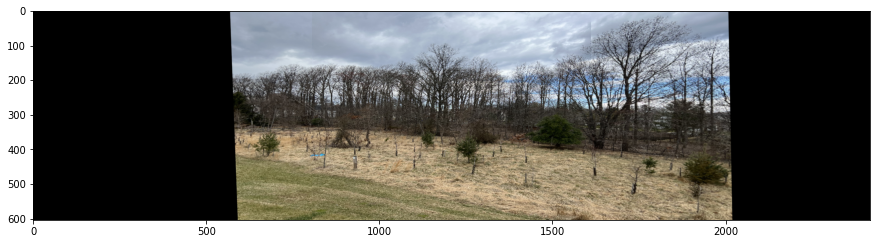

In [ ]:
stitch_images(img1 , img2, img3, img4)

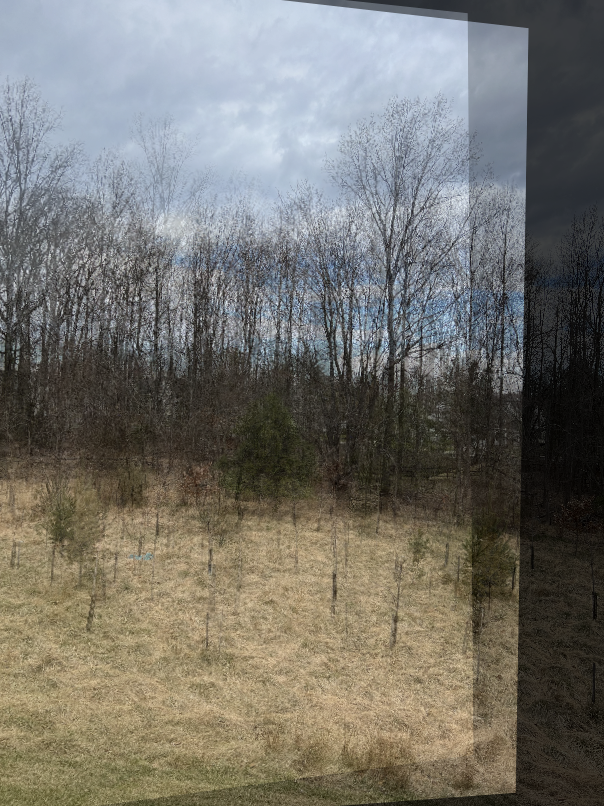

In [ ]:
img123 = stitch_images(img12, img3)
cv2_imshow(img123)

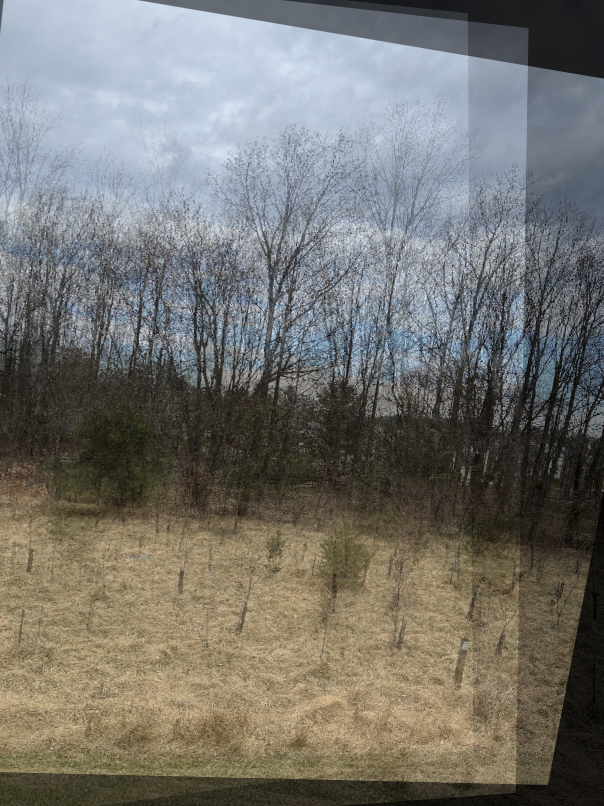

In [ ]:
img1234 = stitch_images(img123, img4)
cv2_imshow(img1234)